In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Load the dataset
#file_path = '/content/drive/MyDrive/Text_as_Data_Project/all_tweets.csv'
file_path = '/content/all_tweets.csv'
df = pd.read_csv(file_path)



# Download NLTK resources
nltk.download('stopwords')
nltk.download('vader_lexicon')

# Initialize
stop_words = set(stopwords.words('english'))
sid = SentimentIntensityAnalyzer()

# Clean tweets
def clean_tweet(tweet):
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet)
    tweet = re.sub(r'\@\w+|\#', '', tweet)
    tweet = re.sub(r'[^\w\s]', '', tweet)
    tweet = tweet.lower()
    tweet = ' '.join([word for word in tweet.split() if word not in stop_words])
    return tweet

irrelevant_accounts = ['muslimtv', 'mtaafrica', 'mtacanada', 'mtai', 'muslimtvafrica', 'muslimtvusa', 'newsmta', 'muslimtvde', 'muaythaiauthor']

handles_clean = df['Handle'].str.lstrip('@').str.lower()
df = df[~handles_clean.isin(irrelevant_accounts)]

df['cleaned'] = df['Content'].astype(str).apply(clean_tweet)
df['sentiment'] = df['cleaned'].apply(lambda x: sid.polarity_scores(x)['compound'])




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [19]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np
import pandas as pd

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model and tokenizer
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)

# Function to score sentiment
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True).to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
    probs = torch.softmax(logits, dim=1).cpu().numpy()[0]  # Move to CPU for numpy
    labels = ['negative', 'neutral', 'positive']
    return dict(zip(labels, probs)), labels[np.argmax(probs)]

# Apply to your DataFrame
results = []
for text in df['cleaned']:
    scores, label = predict_sentiment(text)
    results.append({**scores, "predicted_label": label})

# Combine results
results_df = pd.DataFrame(results)
df_out = pd.concat([df.reset_index(drop=True), results_df], axis=1)

# Save to CSV
df_out.to_csv("tweets_with_sentiment.csv", index=False)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [24]:
sentiment_df= pd.read_csv('/content/tweets_with_sentiment.csv')
sentiment_df.dtypes


,0
Name,object
Handle,object
Verified,bool
Content,object
Comments,object
Retweets,object
Likes,object
Analytics,object
Tags,object
Mentions,object


In [26]:
sentiment_df.rename(columns={'sentiment': 'vader_score'}, inplace=True)
sentiment_df.shape

(34544, 21)

In [27]:
# 1. First calculate the raw difference
sentiment_df['nlp_sentiment'] = sentiment_df['positive'] - sentiment_df['negative']

# 2. Then normalize between -1 and 1
min_val = sentiment_df['nlp_sentiment'].min()
max_val = sentiment_df['nlp_sentiment'].max()

sentiment_df['nlp_sentiment_normalized'] = 2 * (sentiment_df['nlp_sentiment'] - min_val) / (max_val - min_val) - 1
sentiment_df.shape

(34544, 23)

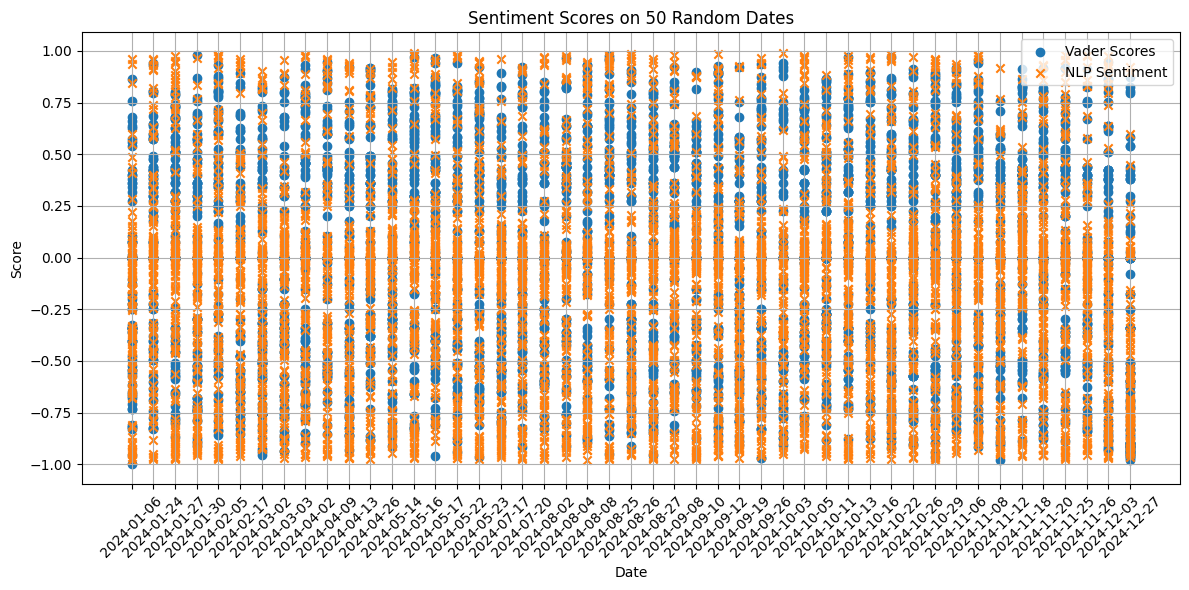

In [ ]:
import matplotlib.pyplot as plt

# 1. Sample 50 random dates
sampled_dates = sentiment_df['Date'].sample(n=50, random_state=42)  # random_state for reproducibility

# 2. Subset the DataFrame to only those dates
subset_df = sentiment_df[sentiment_df['Date'].isin(sampled_dates)].sort_values('Date')  # optional: sort by date

# 3. Plot manually as scatter plots
plt.figure(figsize=(12,6))
plt.scatter(subset_df['Date'], subset_df['vader_score'], label='Vader Scores', marker='o')
plt.scatter(subset_df['Date'], subset_df['nlp_sentiment'], label='NLP Sentiment', marker='x')

# Beautify plot
plt.title('Sentiment Scores on 50 Random Dates')
plt.xlabel('Date')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()


In [28]:
sentiment_df['overall_sentiment']=(sentiment_df['nlp_sentiment_normalized']+sentiment_df['vader_score'])/2
sentiment_df['overall_label']='neutral'
sentiment_df.loc[sentiment_df['overall_sentiment']>=0,'overall_label']='positive'
sentiment_df.loc[sentiment_df['overall_sentiment']<0,'overall_label']='negative'
sentiment_df.shape

(34544, 25)

In [29]:
sentiment_df

,Name,Handle,Verified,Content,Comments,Retweets,Likes,Analytics,Tags,Mentions,...,cleaned,vader_score,negative,neutral,positive,predicted_label,nlp_sentiment,nlp_sentiment_normalized,overall_sentiment,overall_label
0,"Unbiased, Unreported News",@Kiraguri254,False,The New York subway is restless,0,0,1,28,[],[],...,new york subway restless,-0.2732,0.184088,0.775679,0.040233,neutral,-0.143855,-0.151262,-0.212231,negative
1,OUTFRONT Media,@OUTFRONTMEDIAUS,False,Everyone deserves the chance to fly . has tak...,1,2,7,1.2K,['#WickedMovie'],"['@wickedmovie', '@mta', '@grandcentralnyc', '...",...,everyone deserves chance fly taken shuttle see...,0.2500,0.026302,0.580260,0.393438,neutral,0.367136,0.367033,0.308516,positive
2,UnboundedLife,@unboundedlife1,True,What's going on in the NYC Subway again?,0,0,1,160,[],[],...,whats going nyc subway,0.0000,0.035926,0.888815,0.075259,neutral,0.039333,0.034545,0.017272,positive
3,STU Tommies,@TommiesSTU,False,WBB| GAME at 1pm MTA,0,0,0,108,[],[],...,wbb game 1pm mta,0.0000,0.053594,0.828768,0.117638,neutral,0.064044,0.059609,0.029805,positive
4,carol,@oppsarigb,False,loving the nyc subway,0,0,0,56,[],[],...,loving nyc subway,0.5994,0.006608,0.171279,0.822113,positive,0.815505,0.821810,0.710605,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34539,St Patrick's PS Troon,@StPatricksTroon,False,Our pupils taking toys from our toy drive to t...,2,0,4,353,['#community'],[],...,pupils taking toys toy drive mta muirhead tena...,0.0000,0.055166,0.868583,0.076251,neutral,0.021085,0.016036,0.008018,positive
34540,Gene’s Rapture,@EugeneDimitrief,False,#NYC is going worse & worse. #MTA cares not fo...,0,0,0,23,"['#NYC', '#MTA']",[],...,nyc going worse worse mta cares residents incr...,0.8074,0.634295,0.316814,0.048891,negative,-0.585404,-0.599121,0.104140,positive
34541,First of Her Name.,@honorablekey,False,The MTA ain’t never prepared for any inconveni...,0,0,0,50,[],[],...,mta aint never prepared inconvenience need con...,-0.4640,0.802074,0.183483,0.014443,negative,-0.787631,-0.804238,-0.634119,negative
34542,Savraj Singh,@savraj,False,please mandate all electric trains like NYC ...,1,1,5,463,[],"['@elonmusk', '@Tesla']",...,please mandate electric trains like nyc subway...,0.1531,0.334461,0.601203,0.064335,neutral,-0.270126,-0.279337,-0.063118,negative


In [31]:
sentiment_df.to_csv('tweets_with_final_sentiment.csv',index=False)